In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random

In [2]:
!wget -nc https://www.dais.unive.it/~bergamasco/teachingfiles/cvstuff/coins.jpg

--2023-07-21 17:23:31--  https://www.dais.unive.it/~bergamasco/teachingfiles/cvstuff/coins.jpg
Resolving www.dais.unive.it (www.dais.unive.it)... 

157.138.20.11
Connecting to www.dais.unive.it (www.dais.unive.it)|157.138.20.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77876 (76K) [image/jpeg]
Saving to: ‘coins.jpg’

coins.jpg           100%[===================>]  76,05K  --.-KB/s    in 0,1s    

2023-07-21 17:23:32 (756 KB/s) - ‘coins.jpg’ saved [77876/77876]



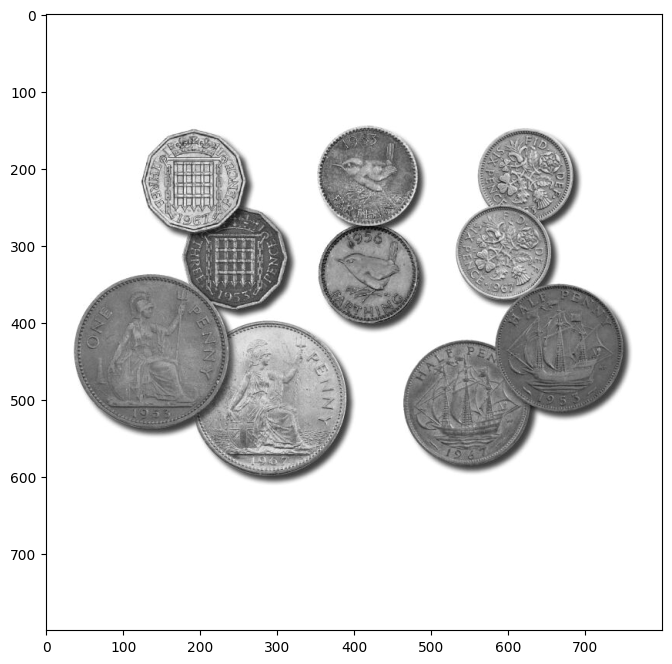

In [3]:
I = cv.imread("coins.jpg", cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,8))
plt.imshow(I, vmin=0, vmax=255, cmap="gray")

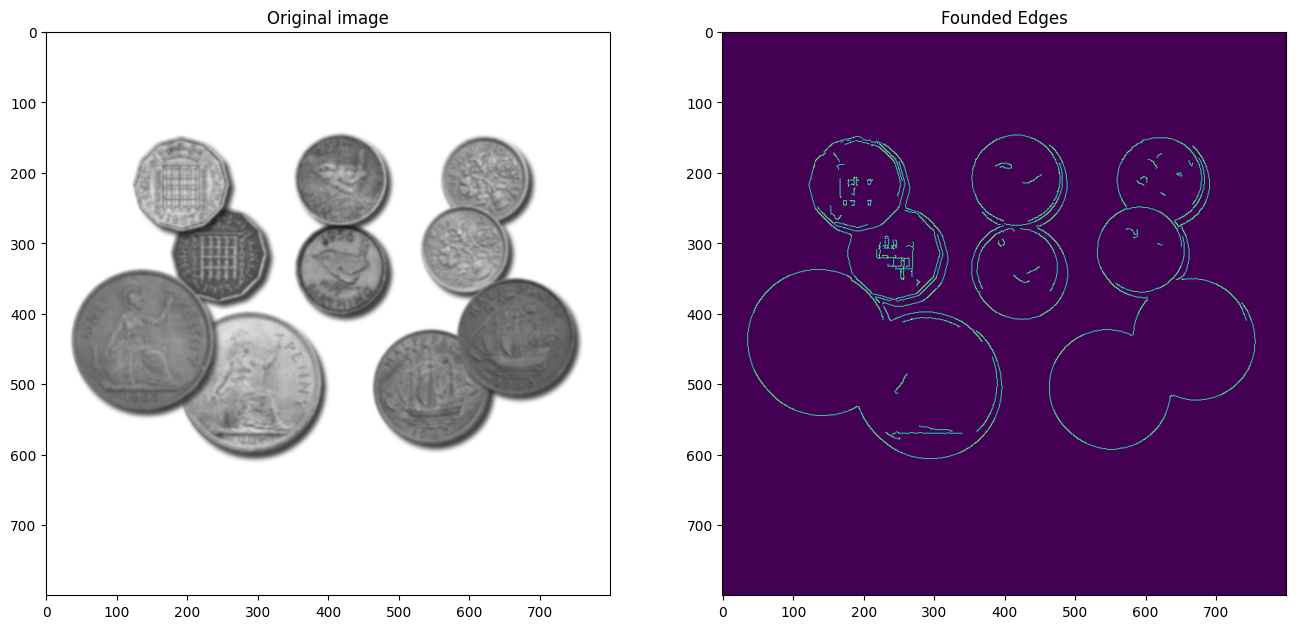

In [10]:
Is = cv.GaussianBlur(I, (15,15), sigmaX=1.5) # Apply GaussianBlur to the original image
edges = cv.Canny(Is, 100, 200) # Canny edge detector

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(Is, vmin=0, vmax=255, cmap="gray")

plt.subplot(1,2,2)
plt.title('Founded Edges')
plt.imshow(edges)

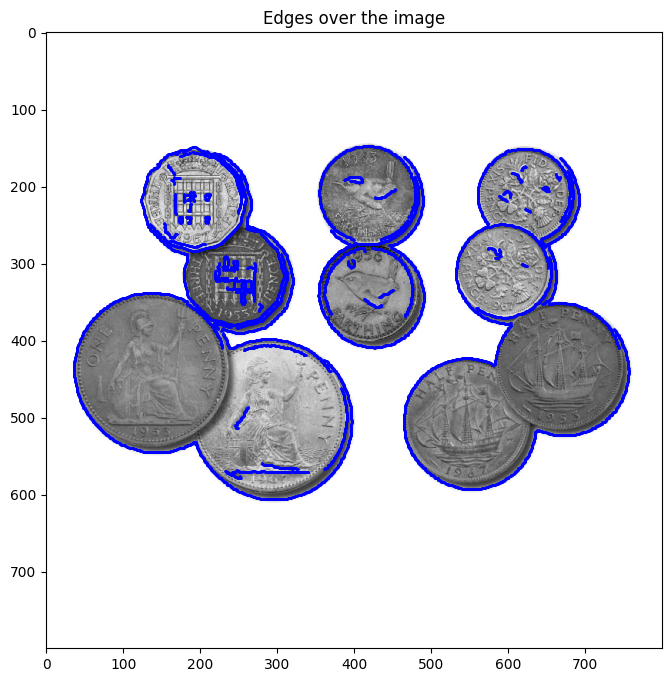

In [13]:
pts = np.array(np.where(edges > 0)) # Coordinates oof the points that compose the edges
pts = pts[::-1,...] # ij to xy

plt.figure(figsize=(8,8))
plt.title('Edges over the image')
plt.imshow(I, vmin=0, vmax=255, cmap="gray")
plt.scatter( pts[0,:],pts[1,:], s=1, c="b")

# Circle fitting

We consider the algebraic distance approximation

\begin{equation*}
\text{dist}(d_x,d_y,\phi) = a {d_x}^2 + b_x d_x + b_y d_y + a {d_y}^2 + c
\end{equation*}

and we solve the following least-squares problem:

\begin{equation*}
\text{argmin} \sum_{i=1}^N \big( \text{dist}(d_{x_i},d_{y_i},\phi) \big)^2
\end{equation*}

with the following normalization constraint on the curve coefficients:

\begin{equation*}
a^2 + b_x^2 + b_y^2 + c^2 = 1
\end{equation*}


In matrix form:

\begin{equation*}
\text{argmin} \; \| \mathbf{A} x \|_2^2  \;\; \text{s.t.} \|x \|^2 = 1
\end{equation*}

where:

\begin{equation*}
A = \begin{pmatrix} 
x_1^2 + y_1^2 & x_1 & y_1 & 1 \\
x_2^2 + y_2^2 & x_2 & y_2 & 1 \\
\vdots & \vdots & \vdots & \vdots \\
x_N^2 + y_N^2 & x_N & y_N & 1
\end{pmatrix} \;, \;\;
x = \begin{pmatrix}
a \\ b_x \\ b_y \\ c
\end{pmatrix}
\end{equation*}

The solution can be found from the right singular vector of $A$ corresponding to the smallest singular value

0.0


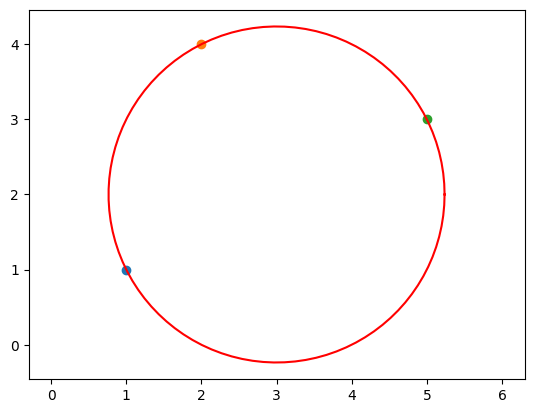

In [6]:
def fit_circle_lls( x_points, y_points ):
    
    A = np.vstack( [x_points**2 + y_points**2, x_points, y_points, np.ones( np.size(x_points))]   ).T
    #print(A)

    _, s, v = np.linalg.svd(A)
    params = v[3,:]
    #print(params)
    xc = -params[1]/(2*params[0]);
    yc = -params[2]/(2*params[0]);
    r = np.sqrt(np.abs((params[1]**2 + params[2]**2)/(4*params[0]**2) - params[3]/params[0]))
    
    return xc, yc, r
    

def fit_circle( p1, p2, p3 ):
    x = np.array( [p1[0],p2[0],p3[0]] )
    y = np.array( [p1[1],p2[1],p3[1]] )
    return fit_circle_lls( x, y )
   

def point_circle_sqr_distance( p, cx, cy, r ):
    return np.abs( (p[0,...]-cx)**2 + (p[1,...]-cy)**2 - r**2 )

    
def plot_circle(xc,yc,r):
    a = np.linspace(0,2*np.pi,100)
    px = np.cos(a)*r + xc
    py = np.sin(a)*r + yc
    plt.plot( px, py, '-r')
    
    
    
p1=np.array((1.0,1.0))
p2=np.array((2.0,4.0))
p3=np.array((5.0,3.0))

xc, yc, r = fit_circle( p1, p2, p3 )
plt.figure()
plt.scatter( p1[0], p1[1] )
plt.scatter( p2[0], p2[1] )
plt.scatter( p3[0], p3[1] )
plot_circle(xc,yc,r)
plt.axis("equal")

print(point_circle_sqr_distance(p1,xc,yc,r))


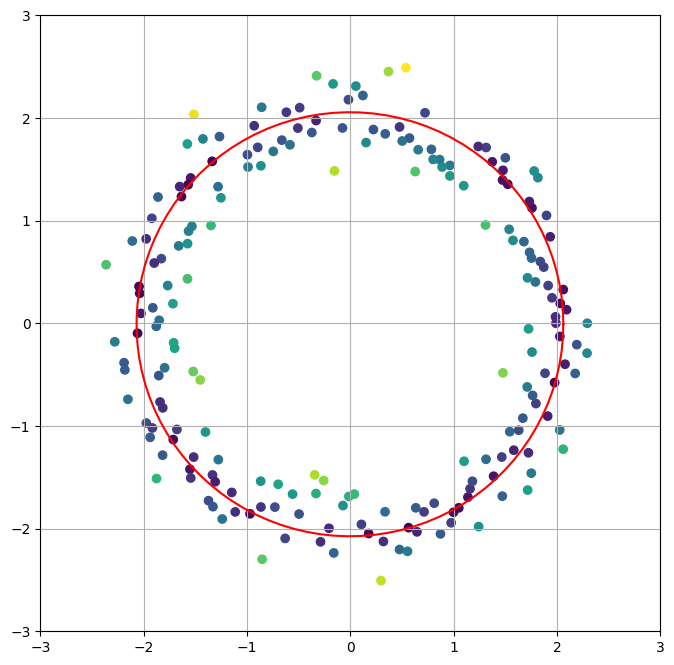

In [7]:
npts = 200
alphas = np.linspace( 0, 2*np.pi, npts)
perturb = 2+np.random.randn( npts )* 0.2;
data = np.vstack(  (perturb*np.cos(alphas), perturb*np.sin(alphas) ) )

xc, yc, r = fit_circle_lls( data[0,:], data[1,:] )

dist_sqr = point_circle_sqr_distance( data, xc, yc, r )

plt.figure( figsize=(8,8))
plt.scatter( data[0,:], data[1,:], c=dist_sqr )
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid(True)
plot_circle(xc,yc,r)

Iteration 0, 25 inliers
Iteration 1, 32 inliers
Iteration 21, 48 inliers
Iteration 23, 155 inliers
Iteration 1280, 205 inliers


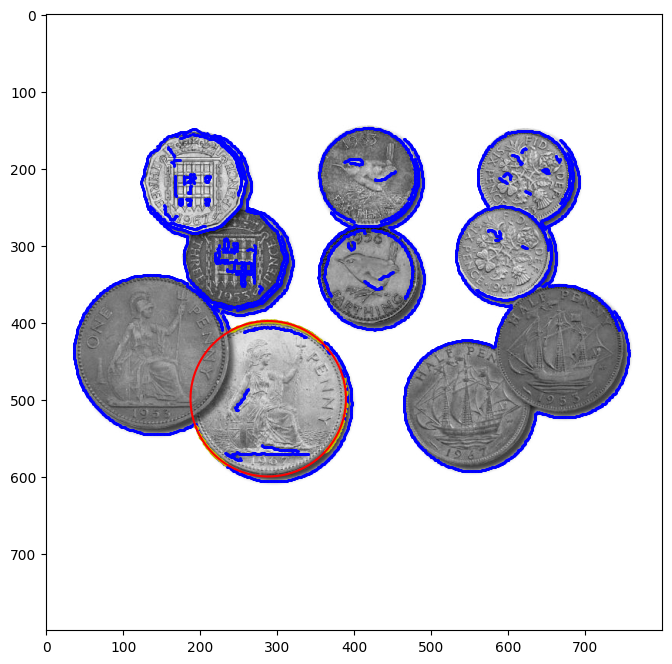

In [8]:
'''
Input needed:
	1- Fucntion that fits a circle given 3 points
	2- Fucntion that returns the distance point-circle
'''

def ransac_circle( data, inlier_distance, num_iters, verbose=True ):
    assert data.shape[0]==2
    
    max_radius = np.amax( data )-np.amin(data)
    best_num_inliers = 0
    best_inliers = None
    best_circle = None
    
    Npts = data.shape[1]
    current_iter = 0
    while current_iter < num_iters:
        
        # choose 3 random points
        idx1 = random.randint(0, Npts-1)
        idx2 = random.randint(0, Npts-1)
        idx3 = random.randint(0, Npts-1)
        
        # fit a circle
        xc, yc, r = fit_circle( data[:,idx1], data[:,idx2], data[:,idx3] )
        
        # we have no guarantee that the 3 random points are not collinear,
        # so we check if the resulting radius is not too large...
        if r>max_radius:
            continue
        
        # compute point distances
        distances_sqr = point_circle_sqr_distance( data, xc, yc, r )
        
        # check number of inliers
        inliers = distances_sqr < inlier_distance**2
        num_inliers = np.sum(inliers)
        
        if num_inliers>best_num_inliers:
            best_num_inliers = num_inliers
            best_inliers = inliers
            best_circle = (xc,yc,r)
            if verbose:
                print("Iteration %d, %d inliers"%(current_iter,num_inliers) )
                
        current_iter += 1
        
    return best_num_inliers, best_inliers, best_circle



n, inliers, best_circle = ransac_circle(pts, 10.0, 2000)

xc,yc,r = best_circle

plt.figure( figsize=(8,8) )
plt.imshow(I, vmin=0, vmax=255, cmap="gray")
plt.scatter( pts[0,:],pts[1,:], s=1, c="b")
plt.scatter( pts[0,inliers],pts[1,inliers], s=3, c="y")
plot_circle(xc,yc,r)

Circle extracted, 7445 points remaining
Circle extracted, 6950 points remaining
Circle extracted, 6583 points remaining
Circle extracted, 5980 points remaining
Circle extracted, 5451 points remaining
Circle extracted, 4603 points remaining
Circle extracted, 3982 points remaining
Circle extracted, 3431 points remaining
Circle extracted, 2910 points remaining
Circle extracted, 2469 points remaining


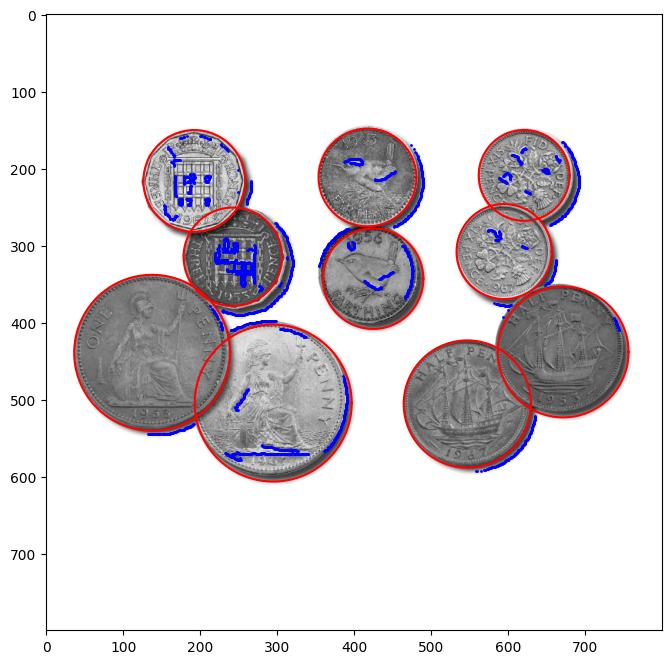

In [9]:
pts_remaining = np.copy( pts )

plt.figure( figsize=(8,8) )
plt.imshow(I, vmin=0, vmax=255, cmap="gray")

for ncircles in range(10):
    n, inliers, best_circle = ransac_circle(pts_remaining, 10.0, 3000, verbose=False )
    xc,yc,r = best_circle
    plot_circle(xc,yc,r)
    
    # remove points close to the currently extracted circle and continue
    distances_sqr = point_circle_sqr_distance( pts_remaining, xc, yc, r )
    points_to_keep = distances_sqr > 30.0**2
    
    pts_remaining = pts_remaining[:,points_to_keep]
    print("Circle extracted, %d points remaining"%pts_remaining.shape[-1])
    
plt.scatter( pts_remaining[0,:],pts_remaining[1,:], s=1, c="b")